# Outline:
1. Load the library
2. Data preparation: 
Import data , Slicing data , Feature engineering
3. Modeling: 
Undersampling + Random forest , Undersampling + C.50
4. Ensemble the model with Mean of Prediction Probability

### 1. Load the library

In [1]:
library(dataPreparation)
library(caret)
library(AUC)
library(data.table)
library(ebmc)
library(DMwR)
library(xgboost)
library(plyr)
library(InformationValue)


Loading required package: lubridate

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Loading required package: stringr
Loading required package: Matrix
Loading required package: progress
dataPreparation 0.3.8
Type dataPrepNews() to see new features/changes/bug fixes.
Warning message:
"package 'caret' was built under R version 3.5.3"Loading required package: lattice
Loading required package: ggplot2
AUC 0.3.0
Type AUCNews() to see the change log and ?AUC to get an overview.

Attaching package: 'AUC'

The following objects are masked from 'package:caret':

    sensitivity, specificity


Attaching package: 'data.table'

The following objects are masked from 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

Loading required package: grid

Attaching package: 'plyr'

The following object is masked from 'package:DMwR':

    join

The following object is masked from 'package:lubridate':

   

### 2. Data preparation

### 2.1 Import data

In [2]:
#import data
# df_y + df_x (mean) + df_y (median) + df_freq
data.01<-read.csv("D:\\DATA SCIENTIST\\DS-GRAB COMPETITION\\safety\\df_gabung3.csv", header = T, sep=",")
data.01<-data.01[,-c(1,2,25:33)]
setnames(data.01, "Accuracy", "Freq")
str(data.01)

'data.frame':	20000 obs. of  22 variables:
 $ label           : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Accuracy_x      : num  10 13.03 10.23 6.12 4.19 ...
 $ Bearing_x       : num  249 182 160 124 123 ...
 $ acceleration_x_x: num  0.1586 -0.2176 0.0173 0.5097 0.2121 ...
 $ acceleration_y_x: num  -8.01 8.94 -9.72 8.64 9.83 ...
 $ acceleration_z_x: num  -5.159 -3.094 0.558 4.469 1.347 ...
 $ gyro_x_x        : num  -0.03937 0.00364 -0.00688 0.00203 0.00368 ...
 $ gyro_y_x        : num  5.87e-02 -2.19e-02 6.29e-03 3.11e-03 -3.66e-05 ...
 $ gyro_z_x        : num  0.00274 0.00576 0.02043 0.00191 -0.00225 ...
 $ second_x        : num  250.9 344.7 599.5 464.7 97.5 ...
 $ Speed_x         : num  6.02 5.85 16.9 4.19 9.33 ...
 $ Accuracy_y      : num  10 13.7 10 6 3.9 ...
 $ Bearing_y       : num  261.5 180.5 114.8 89 84.5 ...
 $ acceleration_x_y: num  0.156 -0.2673 0.0191 0.4926 0.2696 ...
 $ acceleration_y_y: num  -8 8.93 -9.76 8.65 9.84 ...
 $ acceleration_z_y: num  -5.154 -3.203 0.546 4.503 1.273 ...

### 2.2 Slicing data

In [3]:
#slicing data
set.seed(1000)
index = createDataPartition(data.01$label, p = 0.8, list = F )
data.train = data.01[index,]
data.test = data.01[-index,]

### 2.3 Feature engineering

#### Discretization

In [4]:
#discretization with 10 bin using equal freq
disk=build_bins(data.train[,-1], cols = 'auto', n_bins = 10, type = 'equal_freq')

disk.tr  =as.data.frame(fastDiscretization(dataSet = data.train[,-1], bins = disk))
disk.ts  =as.data.frame(fastDiscretization(dataSet = data.test[,-1], bins = disk))
str(disk.tr)

[1] "fastDiscretization: I will build splits for 21 numeric columns using, equal_freq method."
[1] "equal_freq_splits: Accuracy_y can't provide 10 equal freq bins; instead you will have 7 bins."
[1] "fastDiscretization: it took me: 0.05s to build splits for 21 numeric columns."
[1] "fastDiscretization: I will discretize 21 numeric columns using, bins."
[1] "fastDiscretization: it took me: 1.7s to transform 21 numeric columns into, binarised columns."
[1] "fastDiscretization: I will discretize 21 numeric columns using, bins."
[1] "fastDiscretization: it took me: 0.44s to transform 21 numeric columns into, binarised columns."
'data.frame':	16000 obs. of  21 variables:
 $ Accuracy_x      : Factor w/ 10 levels "[10.0425055928412, 13.4186369958275[",..: 9 1 1 7 4 9 2 3 2 4 ...
 $ Bearing_x       : Factor w/ 10 levels "[104.453333333333, 123.386248784476[",..: 9 6 4 2 1 7 6 2 5 3 ...
 $ acceleration_x_x: Factor w/ 10 levels "[-0.0636025189040997, 0.0565739685178363[",..: 5 3 1 8 6 9 10 2 3 1

In [5]:
# Information value (IV) of discritize
# Discret variable selection using the IV
# Do to all the discret variabel
IV(X=disk.tr[,21], Y=data.train$label) # IV > 0.02 is somewhat predictive
# 4,5,9,10,14,15,19,20,21 are the selected variable 

[1] 0.2789447
attr(,"howgood")
[1] "Highly Predictive"

In [6]:
#discret variable with IV > 0.02
disk.tr=disk.tr[,c(4,5,9,10,14,15,19,20,21)]
disk.ts=disk.ts[,c(4,5,9,10,14,15,19,20,21)]
str(disk.tr)

'data.frame':	16000 obs. of  9 variables:
 $ acceleration_y_x: Factor w/ 10 levels "[-8.77607093641493, 7.56241332586207[",..: 1 4 10 3 9 1 10 5 1 6 ...
 $ acceleration_z_x: Factor w/ 10 levels "[-0.357214644760932, 0.210402011871338[",..: 10 10 4 8 5 8 1 6 2 6 ...
 $ second_x        : Factor w/ 10 levels "[172.393617021277, 251.568181818182[",..: 1 3 7 5 10 8 2 9 5 9 ...
 $ Speed_x         : Factor w/ 10 levels "[10.139604055, 11.9077514592071[",..: 6 6 3 4 9 7 10 1 10 9 ...
 $ acceleration_y_y: Factor w/ 10 levels "[-8.88349304199219, 7.70477625[",..: 1 4 10 3 9 1 10 5 1 6 ...
 $ acceleration_z_y: Factor w/ 10 levels "[-0.356494140625, 0.20590763[",..: 10 10 4 8 5 8 1 6 1 6 ...
 $ second_y        : Factor w/ 10 levels "[172, 247[","[247, 314.5[",..: 10 3 6 4 10 8 1 9 5 9 ...
 $ Speed_y         : Factor w/ 10 levels "[1.7420405, 3.04[",..: 7 7 4 10 2 7 10 9 10 9 ...
 $ Freq            : Factor w/ 10 levels "[1010, 1178[",..: 10 5 2 7 10 3 4 1 9 3 ...


#### Weight of evidence (woe)

In [7]:
# Transform the discret variable to woe variable
x.woe.tr <- NULL
koln.tr <- NULL
for (i in 1:9) {
x.woe.tr <- WOE(X=disk.tr[,i], Y=data.train$label)
koln.tr <- cbind(koln.tr,x.woe.tr)
}
koln.tr=data.frame(koln.tr)
head(koln.tr)

x.woe.tr,x.woe.tr.1,x.woe.tr.2,x.woe.tr.3,x.woe.tr.4,x.woe.tr.5,x.woe.tr.6,x.woe.tr.7,x.woe.tr.8
0.63360195,0.10682545,-0.7581961,0.002672915,0.56774212,0.10364750,-1.18288467,-0.08531238,-0.7301396
-0.15297258,0.10682545,-0.3968339,0.002672915,-0.14573104,0.10364750,-0.48096291,-0.08531238,-0.4847639
-0.16469097,-0.03698115,0.2869114,-0.429516143,-0.13851848,-0.06790996,0.03931769,-0.52215589,0.4737330
0.04234664,-0.02421997,-0.1214202,-0.024219970,0.06189868,-0.04805819,-0.20260452,0.54819611,-0.3460039
-0.02504676,-0.19413144,-1.3377257,0.058652765,-0.03522525,-0.11705106,-1.18288467,0.05865277,-0.7301396
0.63360195,-0.02421997,0.6071070,-0.193335580,0.56774212,-0.04805819,0.59707439,-0.08531238,1.1058659


In [8]:
# Multiply the woe variable with 'second' as the most importance variable to increase the importance of the woe variable
koln.tr=koln.tr*data.train$second_x
head(koln.tr)

x.woe.tr,x.woe.tr.1,x.woe.tr.2,x.woe.tr.3,x.woe.tr.4,x.woe.tr.5,x.woe.tr.6,x.woe.tr.7,x.woe.tr.8
158.963057,26.80121,-190.22221,0.670602,142.439624,26.00390,-296.77144,-21.403842,-183.18318
-52.728743,36.82210,-136.78629,0.921338,-50.232629,35.72668,-165.78508,-29.406672,-167.09526
-98.732234,-22.17020,172.00339,-257.494928,-83.041828,-40.71202,23.57095,-313.032455,284.00292
19.679684,-11.25571,-56.42742,-11.255707,28.766071,-22.33400,-94.15606,254.762278,-160.79782
-2.441746,-18.92539,-130.41154,5.717911,-3.434021,-11.41102,-115.31647,5.717911,-71.17948
513.512674,-19.62946,492.03946,-156.691864,460.135539,-38.94952,483.90834,-69.142759,896.26641


In [9]:
x.woe.ts <- NULL
koln.ts <- NULL
for (i in 1:9) {
x.woe.tr <- WOE(X=disk.ts[,i], Y=data.test$label)
koln.ts <- cbind(koln.ts,x.woe.tr)
}
koln.ts=data.frame(koln.ts)
head(koln.ts)

x.woe.tr,x.woe.tr.1,x.woe.tr.2,x.woe.tr.3,x.woe.tr.4,x.woe.tr.5,x.woe.tr.6,x.woe.tr.7,x.woe.tr.8
-0.2355390529,-0.28150677,-0.1392885,0.03544939,-0.26754210,-0.37431008,0.1387972,-0.008535909,-0.20522664
-0.3097274077,-0.03941034,0.2655144,0.03468516,-0.28875975,-0.07924245,0.3685481,0.002995649,0.53558276
-0.2355390529,-0.18460297,0.6034334,-0.14603993,-0.26754210,-0.13173984,0.5489126,0.043174350,0.53558276
0.0424834203,-0.03941034,-0.2267546,0.49682370,0.02268079,-0.07924245,-0.3259294,0.607934564,-0.45572002
0.1626661218,0.44201546,0.1665361,0.03468516,0.16092705,0.45711009,0.1387972,0.015391957,0.30556633
0.0005142579,-0.11614701,-0.2267546,-0.13502006,-0.02891355,-0.03733343,-0.3259294,0.015391957,0.01616611


In [10]:
koln.ts=koln.ts*data.test$second_x
head(koln.ts)

x.woe.tr,x.woe.tr.1,x.woe.tr.2,x.woe.tr.3,x.woe.tr.4,x.woe.tr.5,x.woe.tr.6,x.woe.tr.7,x.woe.tr.8
-118.9031617,-142.10826,-70.31465,17.89531,-135.058716,-188.95657,70.06662,-4.309037,-103.601062
-195.2401128,-24.84275,167.36993,21.86418,-182.022916,-49.95136,232.31837,1.888340,337.610546
-169.9012127,-133.15952,435.27420,-105.34288,-192.985950,-95.02780,395.94672,31.142922,386.331523
13.5711842,-12.58950,-72.43599,158.70864,7.245302,-25.31373,-104.11703,194.202631,-145.578212
85.6945956,232.85940,87.73333,18.27259,84.778431,240.81145,73.12014,8.108680,160.976257
0.1925896,-43.49705,-84.91960,-50.56501,-10.828125,-13.98137,-122.06055,5.764288,6.054209


#### All variable (except 'label') * freq

In [11]:
# Multiply all variable (except 'label') with 'freq' to increase the importance 
data.ready.tr=data.frame(data.train[,-1], koln.tr)*data.train$Freq
data.ready.ts=data.frame(data.test[,-1],koln.ts)*data.test$Freq

# Add the 'label'
data.ready.tr$label=data.train[,1]
data.ready.ts$label=data.test[,1]
str(data.ready.ts)

'data.frame':	4000 obs. of  31 variables:
 $ Accuracy_x      : num  4029 6805 4800 2446 3702 ...
 $ Bearing_x       : num  117880 276151 176789 92839 131145 ...
 $ acceleration_x_x: num  81.4 1180.1 106.7 317.3 738.4 ...
 $ acceleration_y_x: num  6912 12218 12053 5924 8469 ...
 $ acceleration_z_x: num  -127 1805 641 1089 5951 ...
 $ gyro_x_x        : num  2.105 1.425 5.177 5.516 0.647 ...
 $ gyro_y_x        : num  -2.95 4.23 56.64 -5.67 4.93 ...
 $ gyro_z_x        : num  -0.0511 -2.0028 2.364 2.0613 2.8667 ...
 $ second_x        : num  358922 794255 887235 197418 543144 ...
 $ Speed_x         : num  9829 8878 6956 2113 6862 ...
 $ Accuracy_y      : num  2773 4914 4797 2280 4021 ...
 $ Bearing_y       : num  140067 278460 97170 61182 69077 ...
 $ acceleration_x_y: num  19.2 1194.6 168.9 323.3 825.6 ...
 $ acceleration_y_y: num  6929 12239 12058 5925 8486 ...
 $ acceleration_z_y: num  -91.7 1837.2 628.8 1073.5 5952.6 ...
 $ gyro_x_y        : num  2.408 2.271 1.26 2.768 0.755 ...
 $ gyro_

#### Add the new variable

In [12]:
# Add the new variable to increase the AUC
data.ready.tr$axm_x=data.ready.tr$acceleration_x_x*data.ready.tr$second_x
data.ready.tr$aym_x=data.ready.tr$acceleration_y_x*data.ready.tr$second_x
data.ready.tr$azm_x=data.ready.tr$acceleration_z_x*data.ready.tr$second_x
data.ready.tr$gxm_x=data.ready.tr$gyro_x_x*data.ready.tr$second_x
data.ready.tr$gym_x=data.ready.tr$gyro_y_x*data.ready.tr$second_x
data.ready.tr$gzm_x=data.ready.tr$gyro_z_x*data.ready.tr$second_x
data.ready.tr$speedmm_x=data.ready.tr$Speed_x*data.ready.tr$second_x

In [13]:
data.ready.ts$axm_x=data.ready.ts$acceleration_x_x*data.ready.ts$second_x
data.ready.ts$aym_x=data.ready.ts$acceleration_y_x*data.ready.ts$second_x
data.ready.ts$azm_x=data.ready.ts$acceleration_z_x*data.ready.ts$second_x
data.ready.ts$gxm_x=data.ready.ts$gyro_x_x*data.ready.ts$second_x
data.ready.ts$gym_x=data.ready.ts$gyro_y_x*data.ready.ts$second_x
data.ready.ts$gzm_x=data.ready.ts$gyro_z_x*data.ready.ts$second_x
data.ready.ts$speedmm_x=data.ready.ts$Speed_x*data.ready.ts$second_x
str(data.ready.ts)

'data.frame':	4000 obs. of  38 variables:
 $ Accuracy_x      : num  4029 6805 4800 2446 3702 ...
 $ Bearing_x       : num  117880 276151 176789 92839 131145 ...
 $ acceleration_x_x: num  81.4 1180.1 106.7 317.3 738.4 ...
 $ acceleration_y_x: num  6912 12218 12053 5924 8469 ...
 $ acceleration_z_x: num  -127 1805 641 1089 5951 ...
 $ gyro_x_x        : num  2.105 1.425 5.177 5.516 0.647 ...
 $ gyro_y_x        : num  -2.95 4.23 56.64 -5.67 4.93 ...
 $ gyro_z_x        : num  -0.0511 -2.0028 2.364 2.0613 2.8667 ...
 $ second_x        : num  358922 794255 887235 197418 543144 ...
 $ Speed_x         : num  9829 8878 6956 2113 6862 ...
 $ Accuracy_y      : num  2773 4914 4797 2280 4021 ...
 $ Bearing_y       : num  140067 278460 97170 61182 69077 ...
 $ acceleration_x_y: num  19.2 1194.6 168.9 323.3 825.6 ...
 $ acceleration_y_y: num  6929 12239 12058 5925 8486 ...
 $ acceleration_z_y: num  -91.7 1837.2 628.8 1073.5 5952.6 ...
 $ gyro_x_y        : num  2.408 2.271 1.26 2.768 0.755 ...
 $ gyro_

### 3. Modeling

In [14]:
#-----------------------UnderSampling Random Forest--------------------------#
trainctrl= trainControl(method = "cv",number = 5, 
                        sampling = "down")
set.seed(1001)

rf.tree=train(as.factor(label)~., data=data.ready.tr,
              method='rf', trControl=trainctrl)
#prediksi.forest=predict(rf.tree,data.ready.ts) #tidak masalah include y pd data1, krn ia hny akan mencari variabel yg cocok saja
#confusionMatrix(prediksi.forest, as.factor(data.ready.ts$Y),positive = "0")

prob_rf2<-predict(rf.tree, newdata=data.ready.ts, type="prob")[,2]
pred_rf2<-ifelse(prob_rf2<0.5,0,1)

caret::confusionMatrix(as.factor(pred_rf2), as.factor(data.ready.ts$label),positive='1')


Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1925  349
         1 1056  670
                                          
               Accuracy : 0.6488          
                 95% CI : (0.6337, 0.6636)
    No Information Rate : 0.7452          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2469          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.6575          
            Specificity : 0.6458          
         Pos Pred Value : 0.3882          
         Neg Pred Value : 0.8465          
             Prevalence : 0.2547          
         Detection Rate : 0.1675          
   Detection Prevalence : 0.4315          
      Balanced Accuracy : 0.6516          
                                          
       'Positive' Class : 1               
                        

In [15]:
#----------------------------------XgbTree-----------------#
trainctrl= trainControl(method = "cv",number = 5, 
                        sampling = "down")
set.seed(1001)
#install.packages('bnclassify')
c50=train(as.factor(label)~., data=data.ready.tr,
          method='xgbTree', trControl=trainctrl)
#prediksi.forest=predict(rf.tree,data.ready.ts) #tidak masalah include y pd data1, krn ia hny akan mencari variabel yg cocok saja
#confusionMatrix(prediksi.forest, as.factor(data.ready.ts$Y),positive = "0")

prob_c50<-predict(c50, newdata=data.ready.ts, type="prob")[,2]
pred_c50<-ifelse(prob_c50<0.5,0,1)

caret::confusionMatrix(as.factor(pred_c50), as.factor(data.ready.ts$label),
                       positive='1')

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1933  363
         1 1048  656
                                          
               Accuracy : 0.6472          
                 95% CI : (0.6322, 0.6621)
    No Information Rate : 0.7452          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2393          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.6438          
            Specificity : 0.6484          
         Pos Pred Value : 0.3850          
         Neg Pred Value : 0.8419          
             Prevalence : 0.2547          
         Detection Rate : 0.1640          
   Detection Prevalence : 0.4260          
      Balanced Accuracy : 0.6461          
                                          
       'Positive' Class : 1               
                        

### 4. Ensemble the model with Mean of Prediction Probability

In [16]:
#majority vote of ensemble model
#menggunakan rataan dg bobot berbeda tiap model
pred_all2=cbind.data.frame(prob_rf2, prob_c50)
pred_all2$mean=rowMeans(pred_all2)
pred_all2$fix=ifelse(pred_all2$mean>0.49,1,0)
caret::confusionMatrix(as.factor(pred_all2$fix), as.factor(data.ready.ts$label),
                       positive='1')

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1901  337
         1 1080  682
                                          
               Accuracy : 0.6458          
                 95% CI : (0.6307, 0.6606)
    No Information Rate : 0.7452          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2476          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.6693          
            Specificity : 0.6377          
         Pos Pred Value : 0.3871          
         Neg Pred Value : 0.8494          
             Prevalence : 0.2547          
         Detection Rate : 0.1705          
   Detection Prevalence : 0.4405          
      Balanced Accuracy : 0.6535          
                                          
       'Positive' Class : 1               
                        

In [18]:
#Storing Model Performance Scores
library(ROCR)
pred_val <-prediction(pred_all2$fix,
                      data.ready.ts$label)

auc_ROCR <- performance(pred_val, measure = "auc")
auc_ROCR <- auc_ROCR@y.values[[1]]
auc_ROCR

[1] 0.6534945

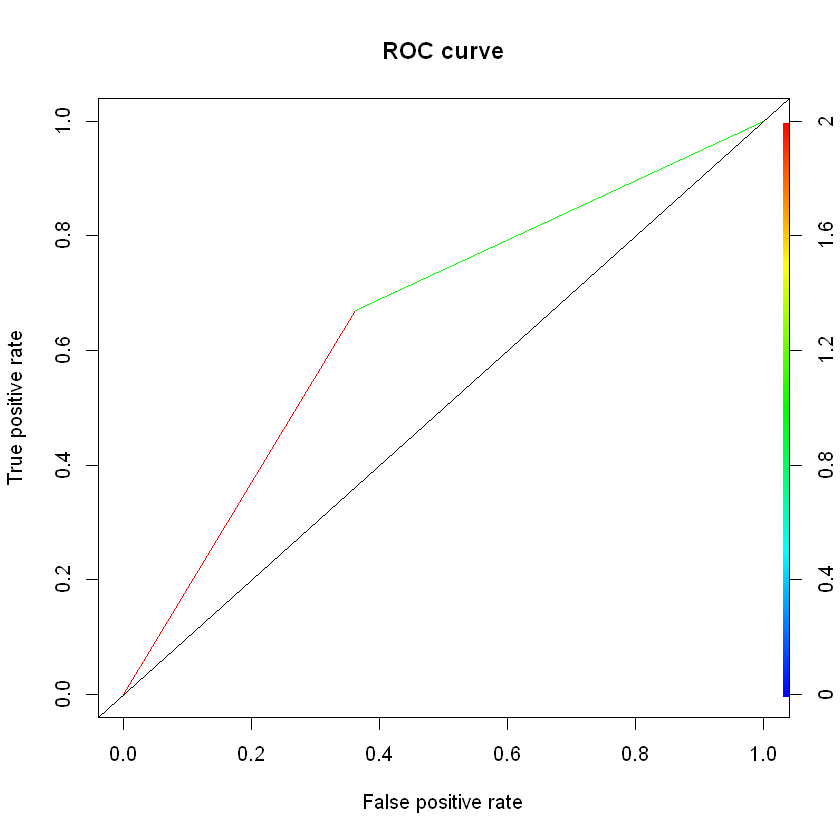

In [19]:
#plot AUC

roc_ROCR <- performance(pred_val, measure = "tpr", x.measure = "fpr")
plot(roc_ROCR, main = "ROC curve", colorize = T)
abline(a = 0, b = 1)
